In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [4]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
nev                    = 10        # which Eigenvector to choose
ϵ                      = 0.2       # perturbation
t₀                      = 0.6      # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [5]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [6]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [7]:
M = assembleMassMatrix(ctx);

In [8]:
@time D⁰ = assembleStiffnessMatrix(ctx)
@time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0))
K = 0.5(D⁰+D¹);

  0.595201 seconds (1.97 M allocations: 149.407 MiB, 9.41% gc time)
 18.346585 seconds (56.96 M allocations: 3.429 GiB, 6.98% gc time)


In [9]:
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ))
Kϵ = 0.5(D⁰+D¹ϵ);

(Complex{Float64}[-2.5784498458817927e-7 + 0.0im, -63.99410430515189 + 0.0im, -123.55046179660421 + 0.0im, -287.9774664306305 + 0.0im, -358.9595884067688 + 0.0im, -373.12336199401364 + 0.0im], Complex{Float64}[-0.004999999927526834 + 0.0im -0.001010635059098634 + 0.0im … 0.0004955196586806596 + 0.0im -0.002974083675078877 + 0.0im; -0.004999999927533686 + 0.0im -0.001010635772453523 + 0.0im … 0.0004955144712829504 + 0.0im -0.002974071039539367 + 0.0im; … ; -0.004999999992243449 + 0.0im -0.00015087840973144773 + 0.0im … 0.0006404375070844131 + 0.0im -0.0014794280792930516 + 0.0im; -0.00499999999290318 + 0.0im -0.0010175208126286586 + 0.0im … 0.00020053949246771048 + 0.0im -0.0009762507620940288 + 0.0im], 6, 3, 42, [1.6224624020341444e-6, 4.822865049723444e-7, 2.769501954362631e-7, -2.3993102216293145e-7, 8.19027768480916e-7, 8.045490928737927e-7, 3.0901565557283337e-6, 4.371950296170433e-7, 1.4390813517523683e-6, -2.088017207218474e-7  …  1.2580127436151539e-6, -5.029224737269734e-7, -1.

In [10]:
# assemble the linear response matrix L
@time L = adaptiveTOCollocationLinearResponseMatrix(ctx, T, 0);

  8.921158 seconds (38.39 M allocations: 3.007 GiB, 8.97% gc time)


In [11]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

 10.901121 seconds (55.61 k allocations: 419.982 MiB, 0.15% gc time)


In [12]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [13]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  3.001872 seconds (4.28 M allocations: 656.588 MiB, 9.23% gc time)
  1.669314 seconds (65.91 k allocations: 452.774 MiB, 9.30% gc time)
  1.478115 seconds (297 allocations: 449.141 MiB, 0.57% gc time)
  1.513129 seconds (297 allocations: 449.141 MiB, 0.62% gc time)
  1.528108 seconds (297 allocations: 449.141 MiB, 0.51% gc time)
  1.499792 seconds (297 allocations: 449.141 MiB, 0.59% gc time)
  1.519942 seconds (297 allocations: 449.141 MiB, 0.45% gc time)
  1.523743 seconds (297 allocations: 449.141 MiB, 0.43% gc time)
  1.529136 seconds (297 allocations: 449.141 MiB, 0.47% gc time)
  1.525924 seconds (297 allocations: 449.141 MiB, 0.36% gc time)


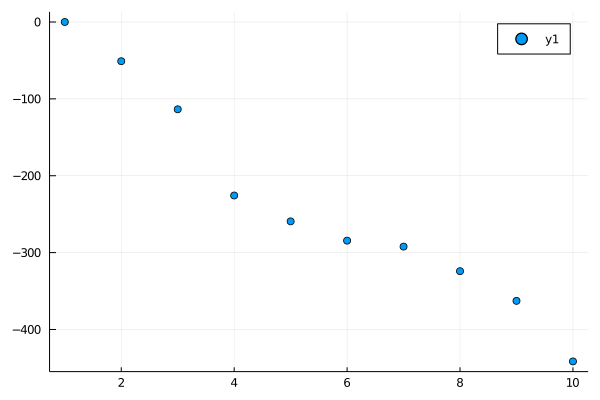

In [14]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [15]:
nev = 3
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [16]:
for i in 1:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

exact ev1: -2.5784498458817927e-7	 predicted ev1: 0.0014933795586848761	 relative error: 5792.7727624993295
exact ev2: -63.994104304957766	 predicted ev2: -61.680994651314734	 relative error: 0.03614566808561191
exact ev3: -123.55046178742124	 predicted ev3: -124.91926900054878	 relative error: 0.011078932391873086


In [17]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmins =     [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]
cmaxs =     -cmins
cmins_lr =  [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]
cmaxs_lr =  -cmins_lr;

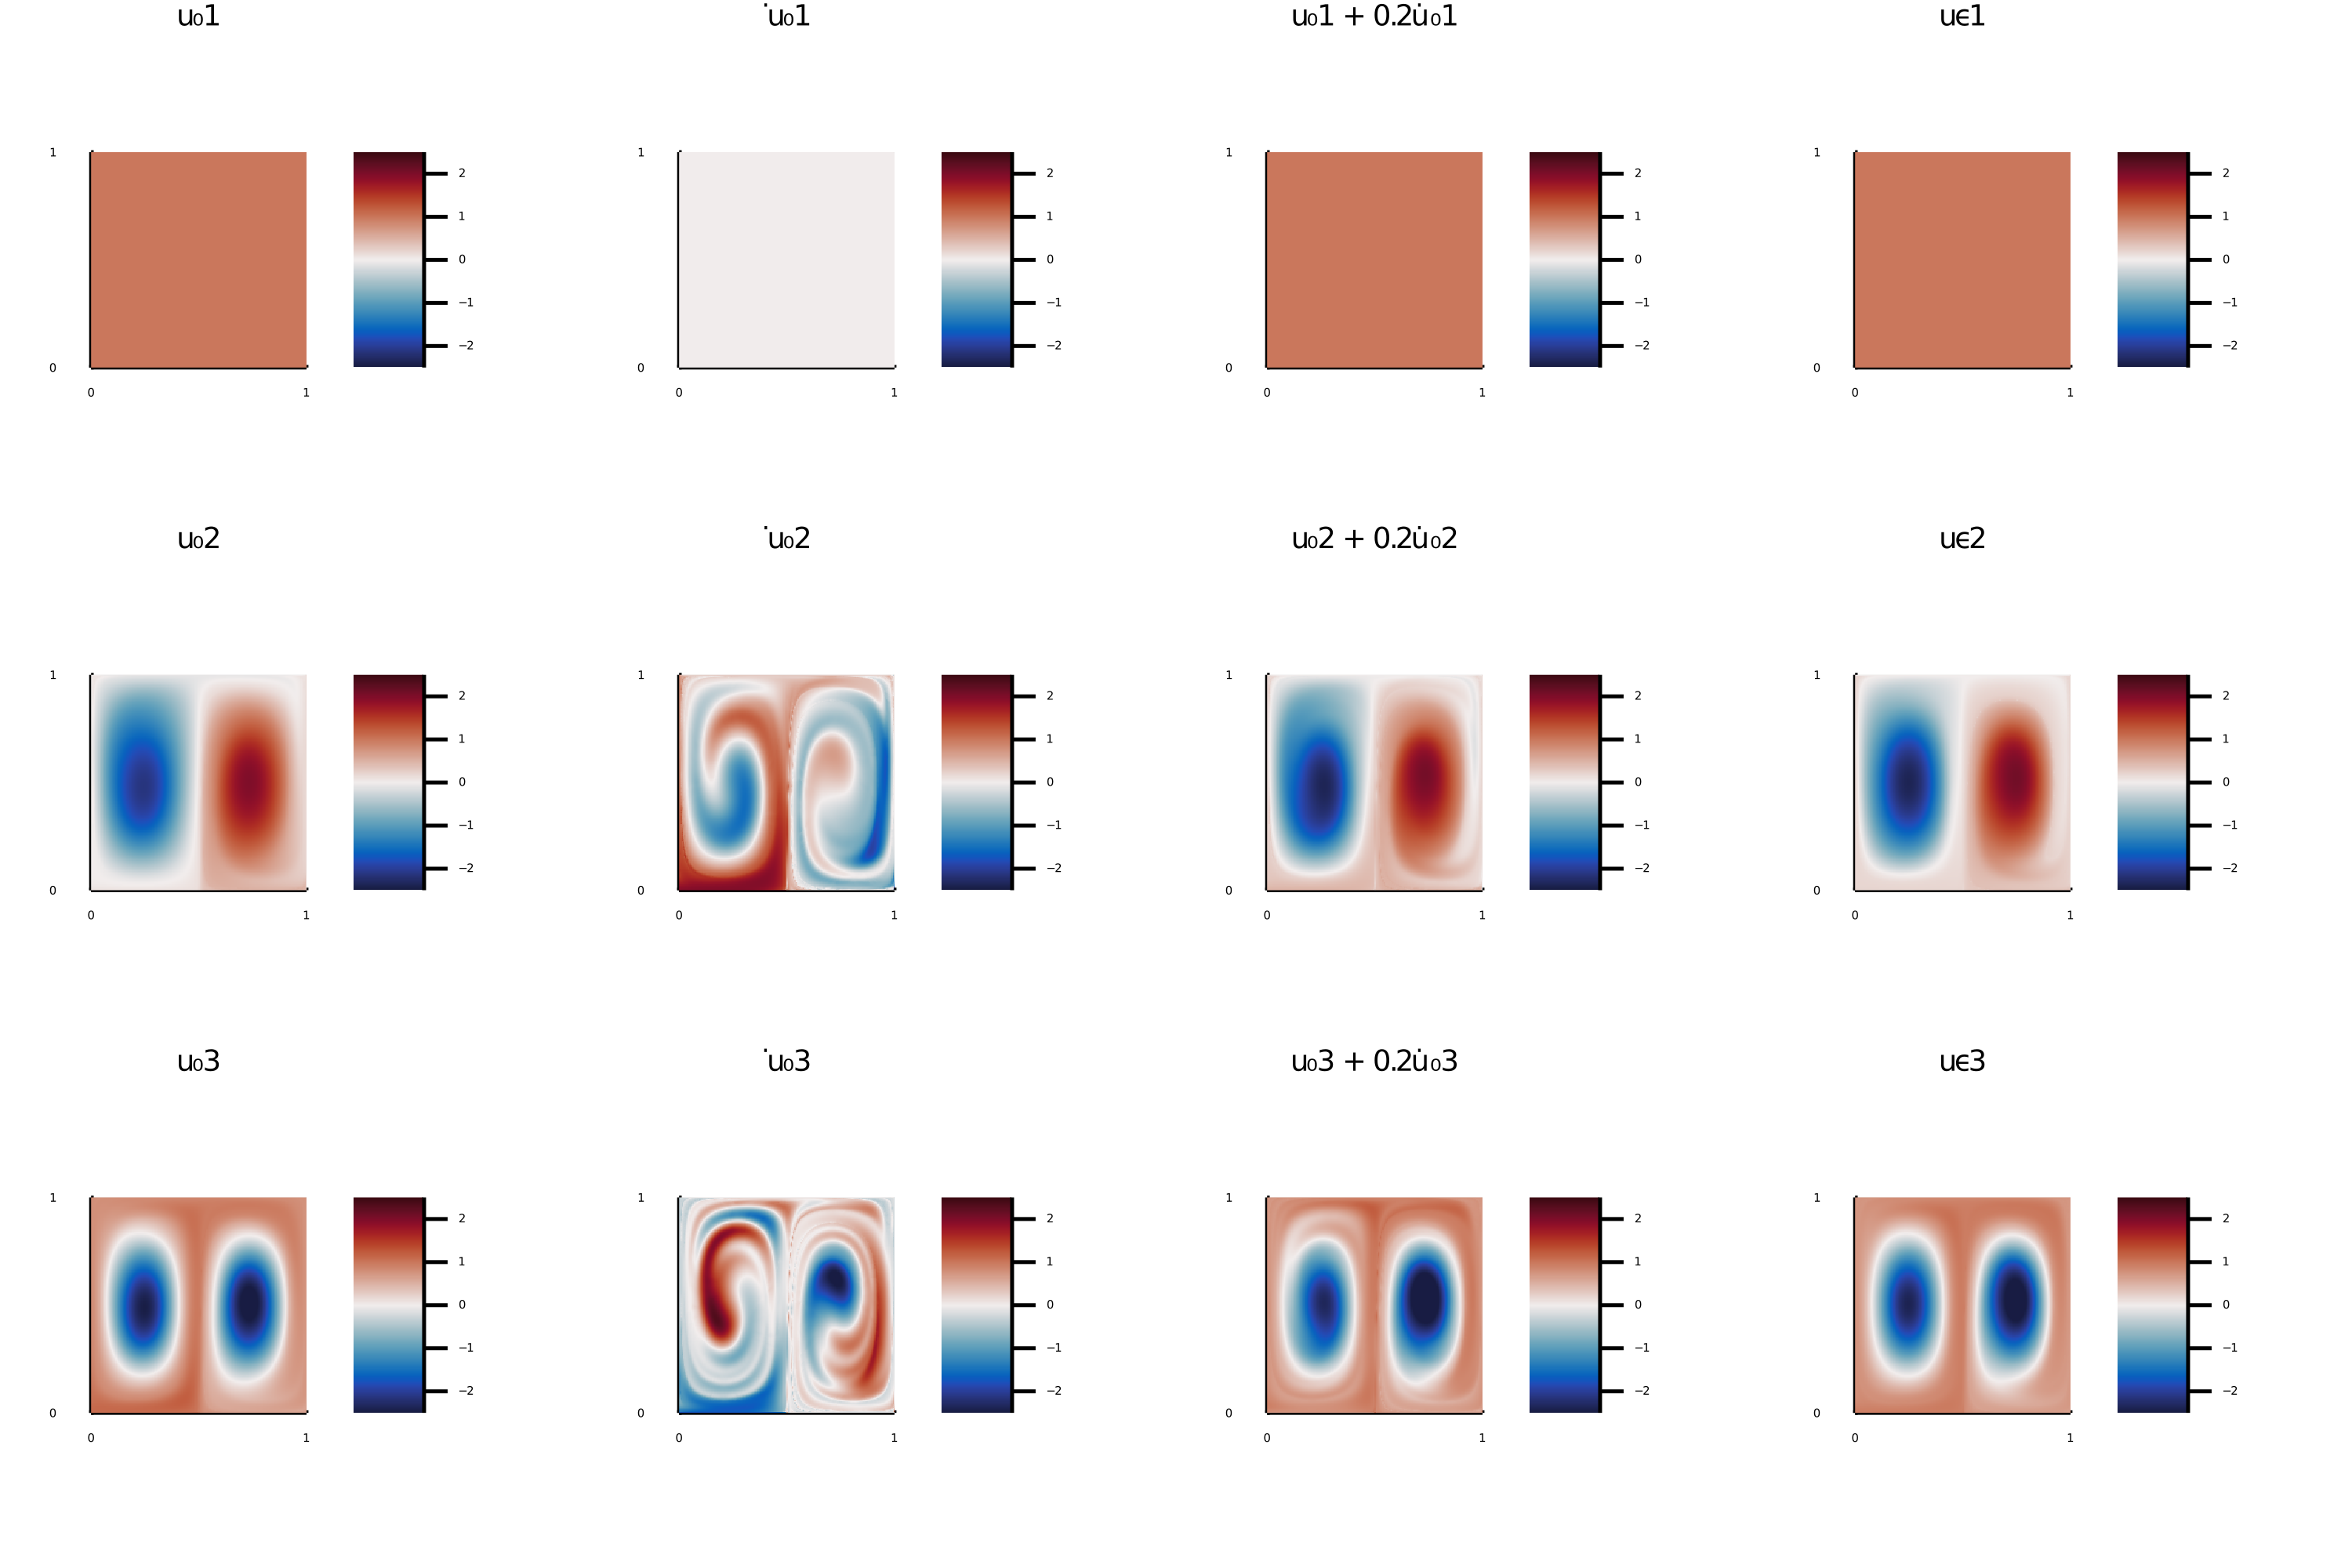

In [18]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  grid_resolution, grid_resolution, 
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  grid_resolution, grid_resolution, 
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  grid_resolution, grid_resolution, 
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  grid_resolution, grid_resolution, 
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [19]:
#limit ourselves to one ev for plotting etc.
ev = 2

2

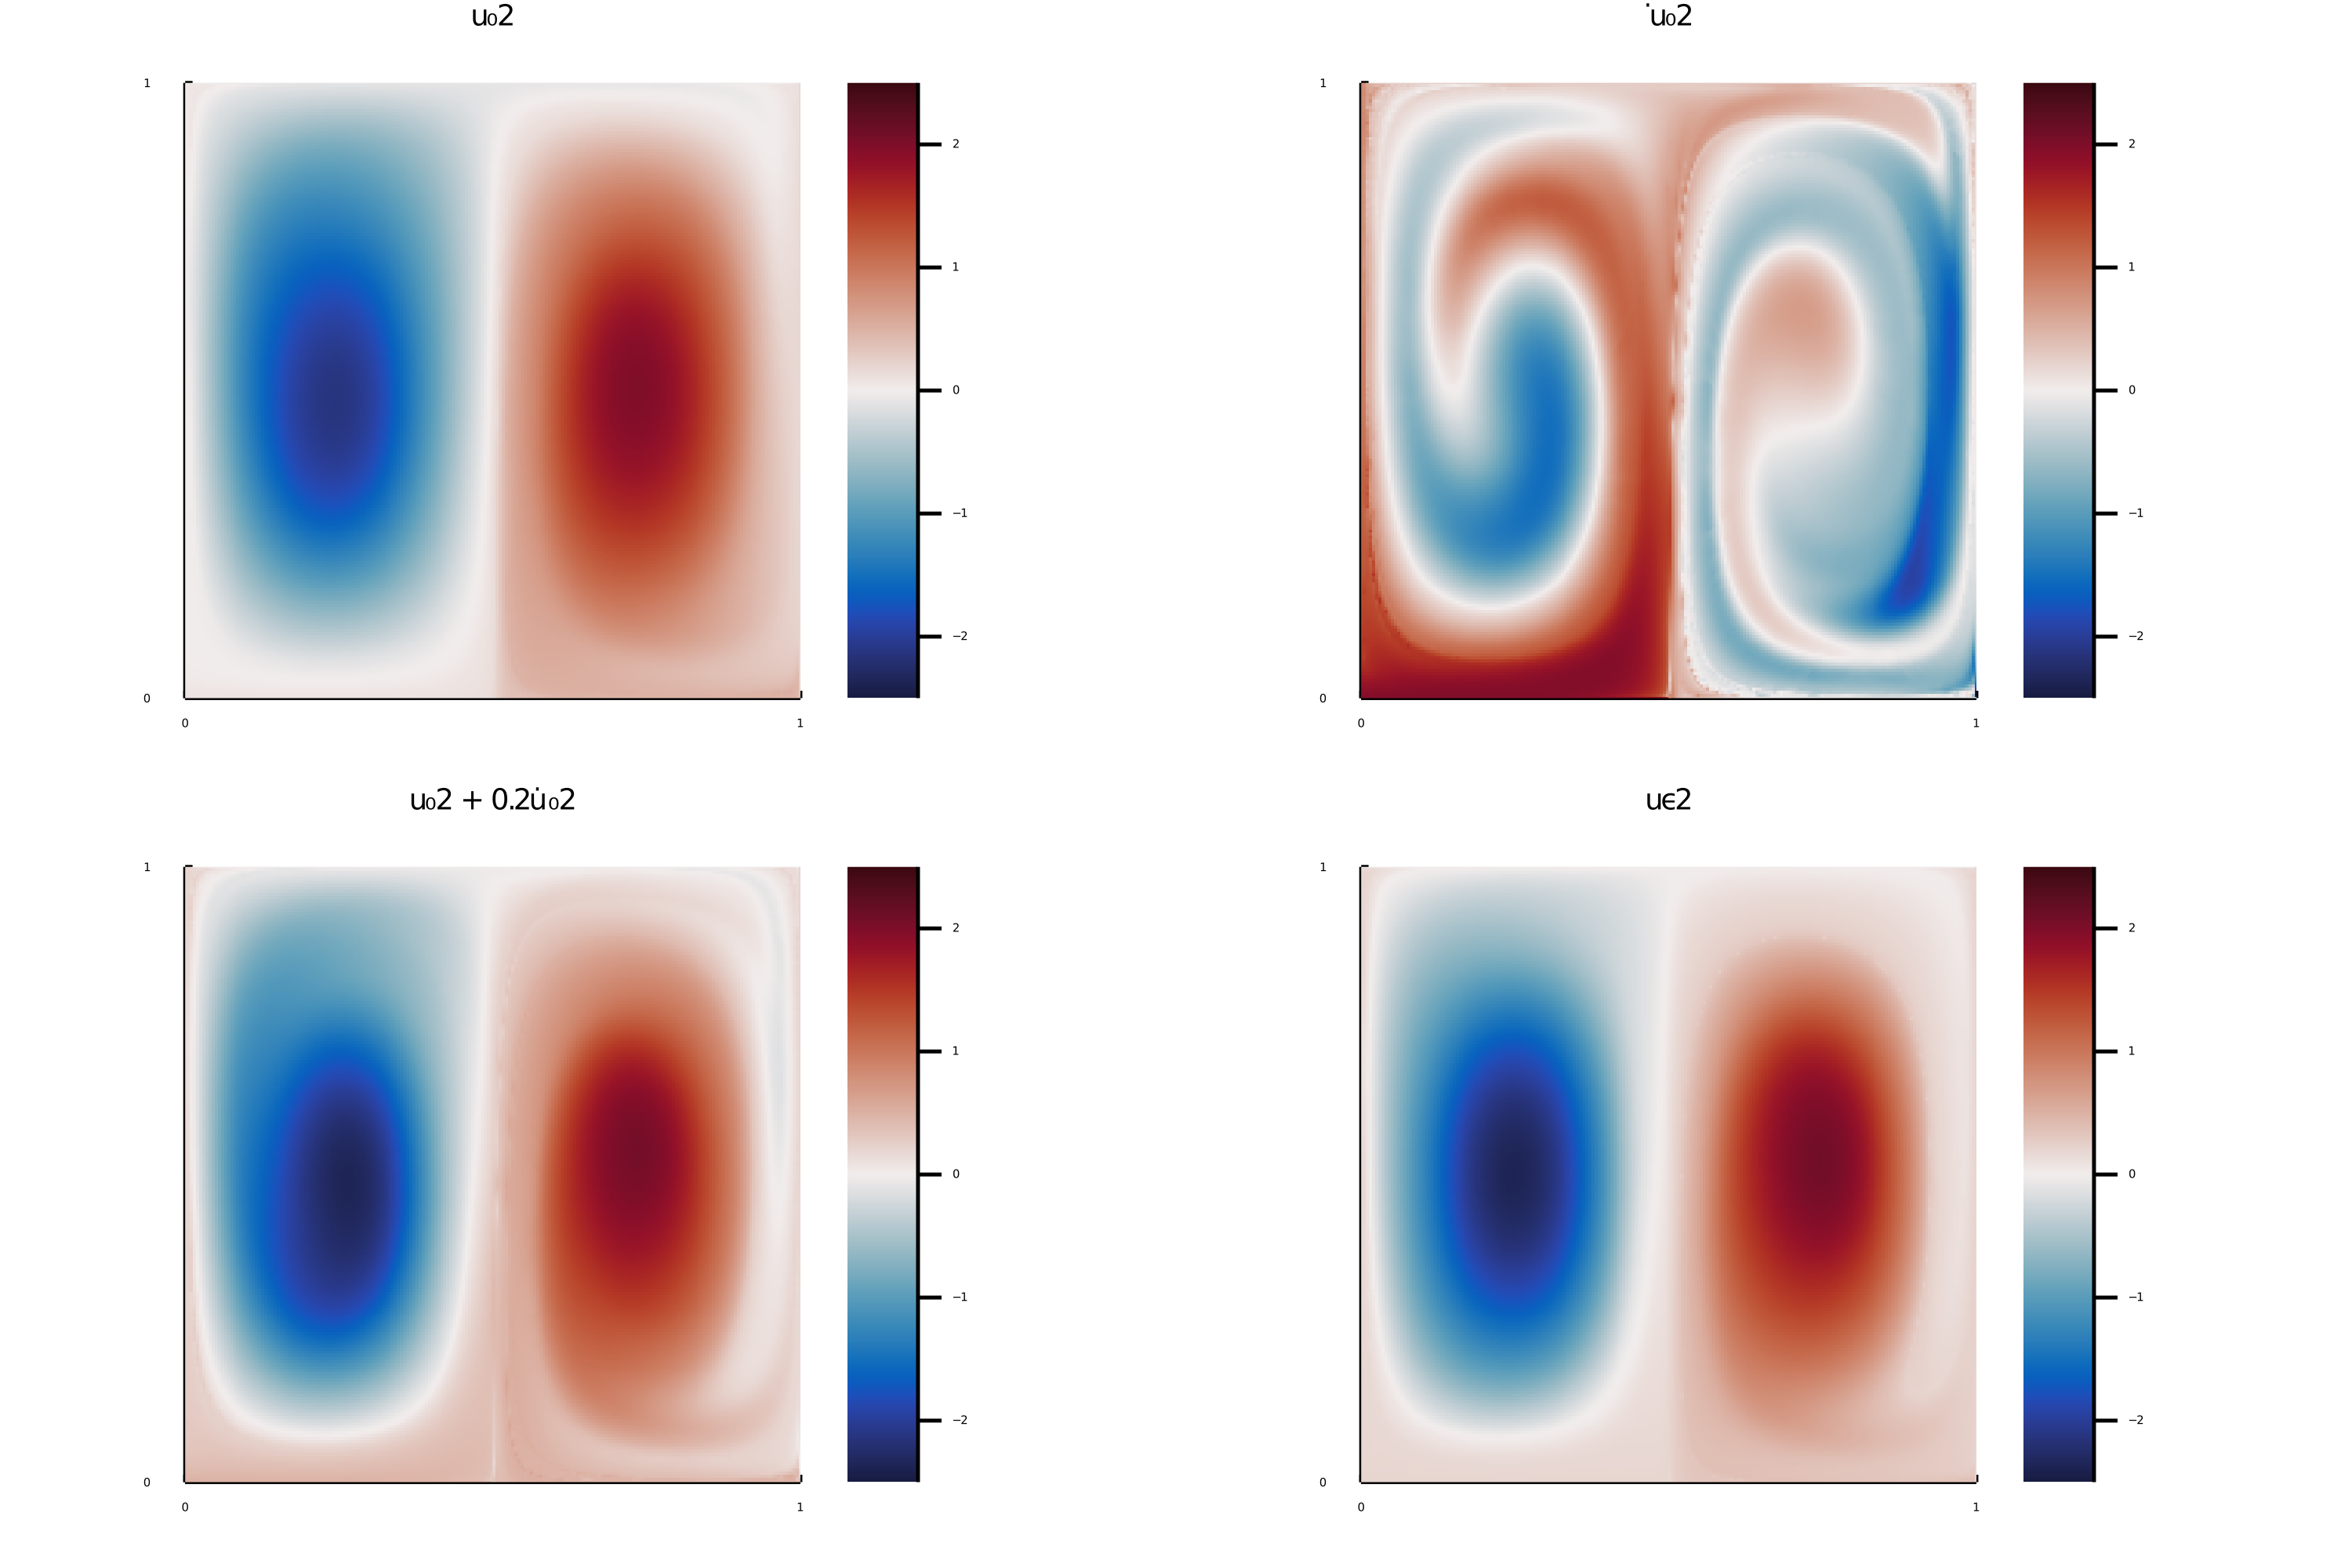

In [20]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  grid_resolution, grid_resolution, 
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [21]:
using Contour

In [22]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [23]:
# Just here to compare with the matlab function

function isClosed(curve)
   return Main.CoherentStructures.closeCurve(ctx,curve,tolerance=1e-10) == curve
end

function dynamic_cheeger_value_matlab(curve)
    image_curve   = Main.CoherentStructures.apply2curve(x->T(x,ϵ),curve)
    
    if !isClosed(curve) || !isClosed(image_curve)
        return Inf
    end
    
    return 0.5(Main.CoherentStructures.getLength(curve)/Main.CoherentStructures.getEuclideanArea(ctx,curve,tolerance=1e-10) +
        Main.CoherentStructures.getLength(image_curve)/Main.CoherentStructures.getEuclideanArea(ctx,image_curve,tolerance=1e-10))
end

dynamic_cheeger_value_matlab (generic function with 1 method)

In [24]:
# resoultion for the levelset methods (default should be 'nothing', that way the grid resolution is used)
x_resolution = 500
y_resolution = 500;

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.07214562103477867)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.06799618913626744)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.022352438252643783)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.01820300635413254)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0140535744556213)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.009904142557110059)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0057547106585988175)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.001605278760087576)
└ @ Main In[25]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.00254415

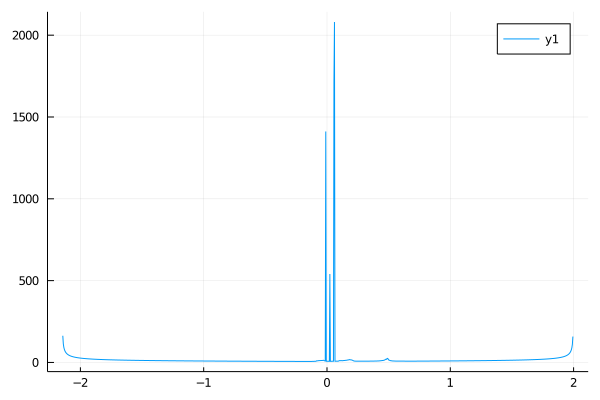

In [25]:
minU = minimum(u₀[:,ev])
maxU = maximum(u₀[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,x_resolution=x_resolution,y_resolution=y_resolution)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.07507507507507508)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.07307307307307308)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.07107107107107107)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.06706706706706707)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.06506506506506507)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.02702702702702703)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.021021021021021023)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.01901901901901902)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0170170170

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4934934934934935)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4954954954954955)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4974974974974975)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4994994994994995)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5015015015015015)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5035035035035035)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5055055055055055)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5075075075075075)
└ @ Main In[26]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5095095095095095)
└ @ Main I

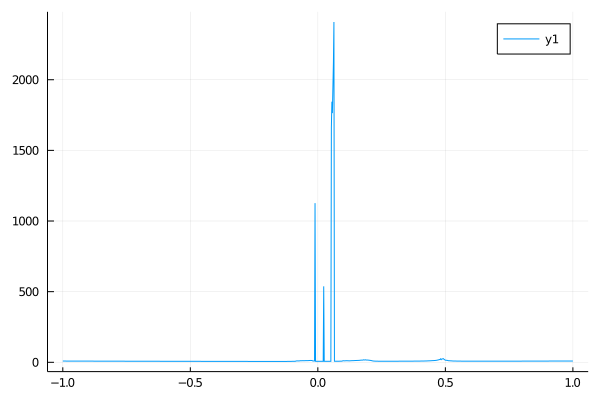

In [26]:
minU = -1
maxU = 1
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,x_resolution=x_resolution,y_resolution=y_resolution)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[1:end],values[1:end])
Plots.plot!(fmt=:png,dpi=100)

In [27]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002000421317639971)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.004000842635279942)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.006001263952919912)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.068014324799759)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07001474611739897)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07201516743503894)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07401558875267891)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5141082786334724)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5161086999511124)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5181091212687524)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5201095425863924)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Wa

Dynamic Cheeger value:	7.101657303511482
Levelset:		0.03000631976459956


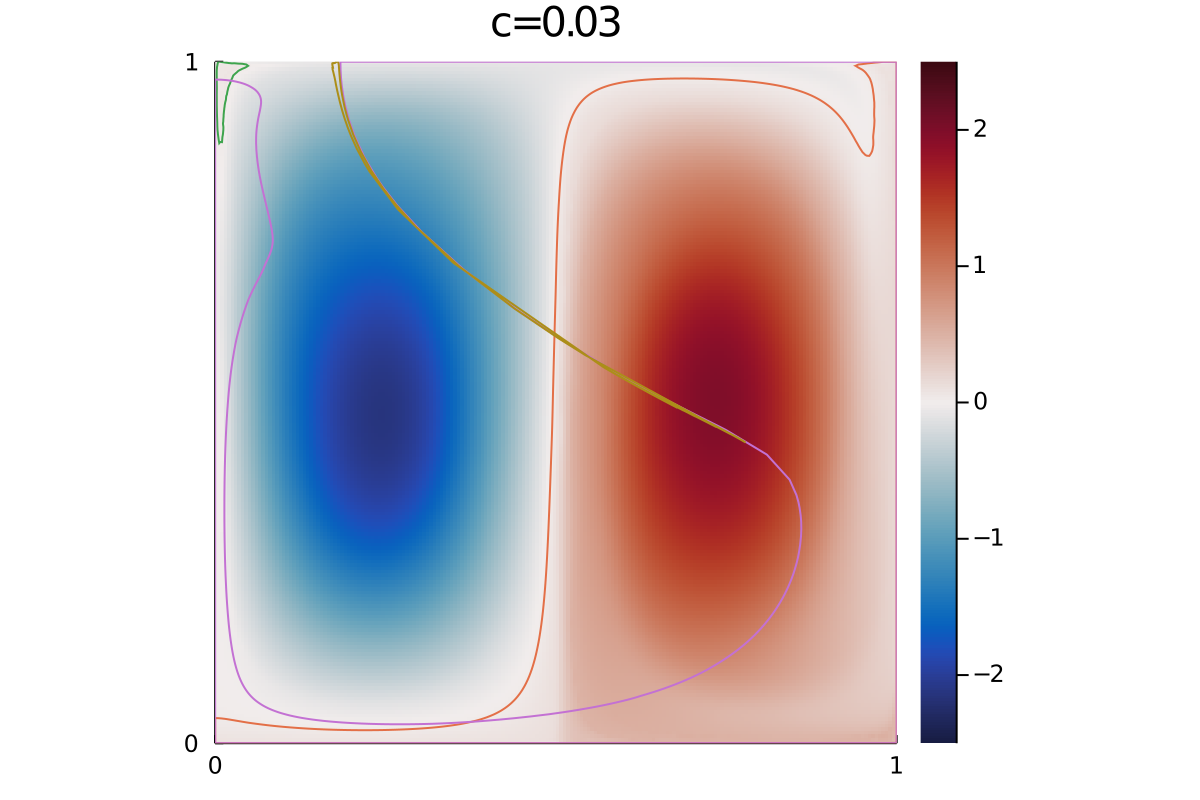

In [28]:
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [29]:
using PyCall
using PyPlot

In [30]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

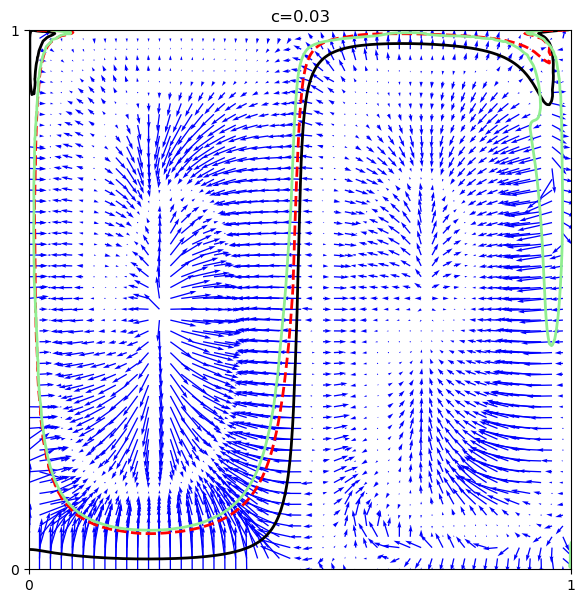

In [31]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev])...,ax,scale=25,step=4)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [32]:
using LinearAlgebra

In [33]:
# we rescale slightly differently here due to normalizeU instead of normalize
cmins =     [-1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1]
cmaxs =     -cmins
cmins_lr =  [-1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1]
cmaxs_lr =  -cmins_lr;

In [34]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)));

In [35]:
μ = 0.99/grid_resolution;

In [36]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.515664 seconds (6.22 M allocations: 432.090 MiB, 5.63% gc time)


In [37]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [38]:
# This is the matrix we effectively multiply u₀ with
Rot = inv(qr(u₀).R)*R'

3×3 Array{Float64,2}:
 -0.00400521    0.00212078   0.00211242
 -0.000126539  -0.00366785   0.00343035
 -0.00296055   -0.00269984  -0.00300128

In [39]:
S_dot = u_dot*Rot;

In [40]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [41]:
S′ = Matrix(qr(u₀).Q)*R';

In [42]:
Sϵ′ = Matrix(qr(uϵ).Q)*Rϵ';

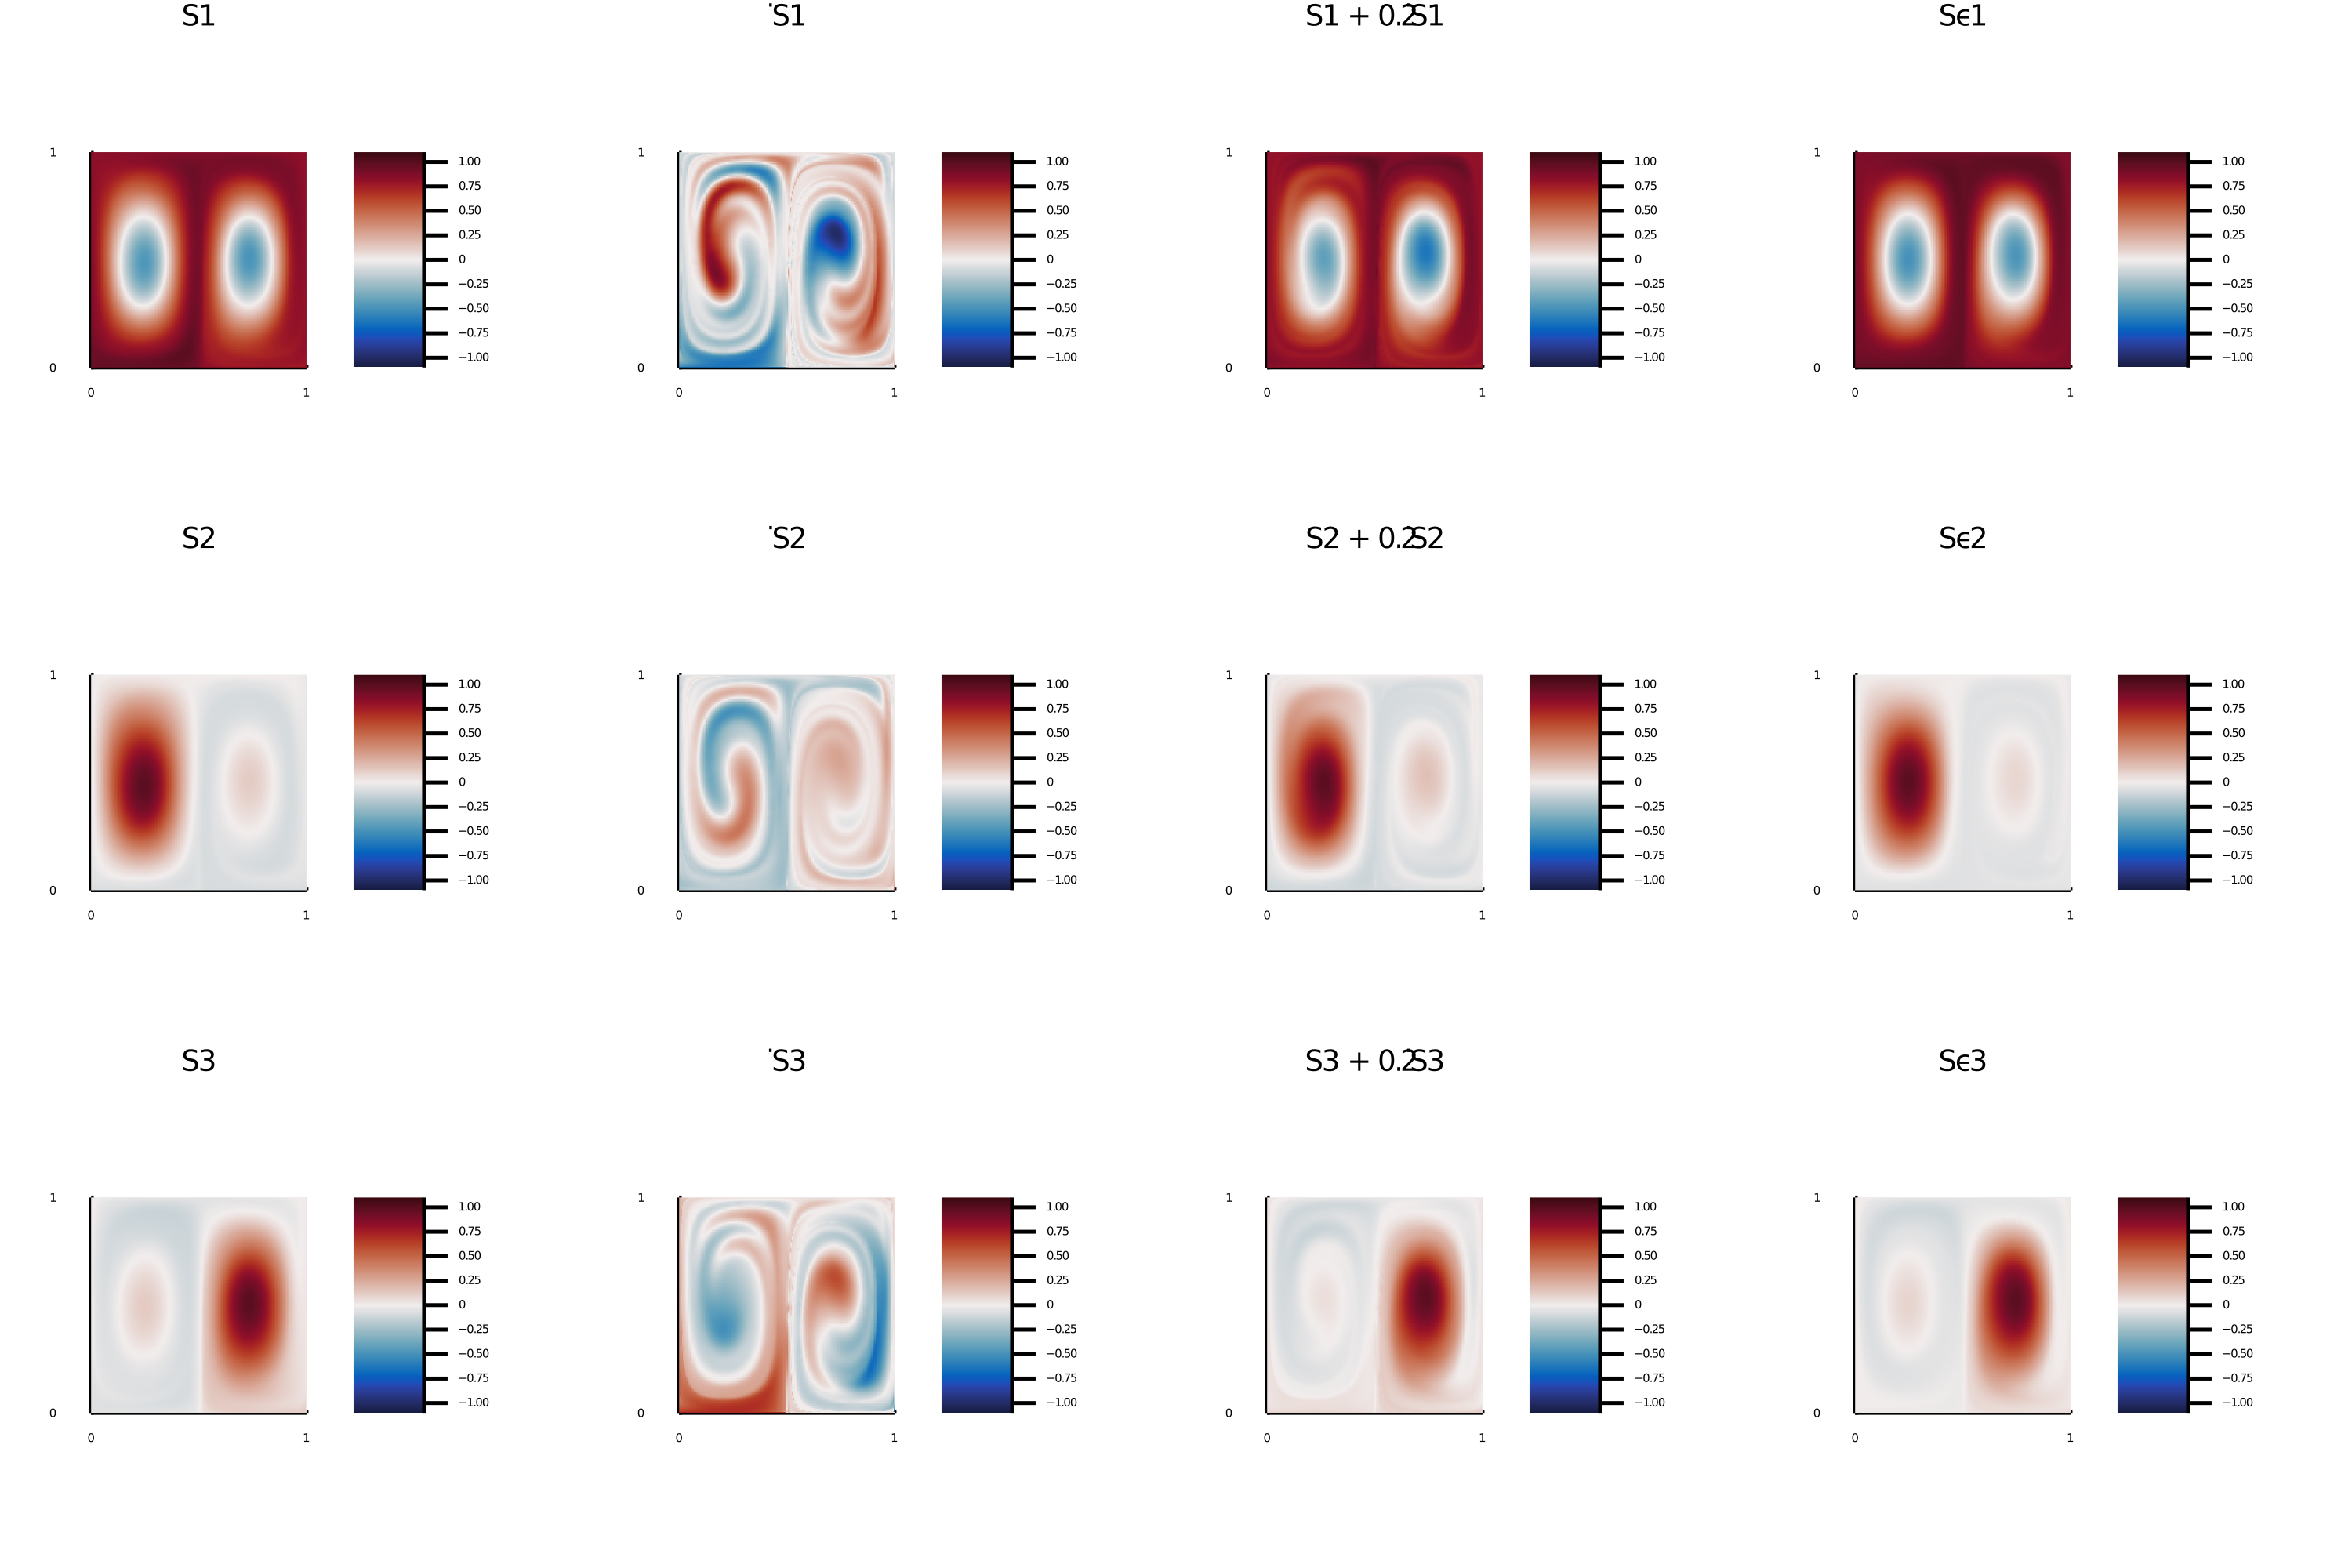

In [43]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(S′[:,i]),  
            grid_resolution, grid_resolution, 
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            grid_resolution, grid_resolution, 
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S′[:,i] + ϵ*S_dot[:,i]),  
            grid_resolution, grid_resolution, 
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,i]),  
            grid_resolution, grid_resolution, 
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

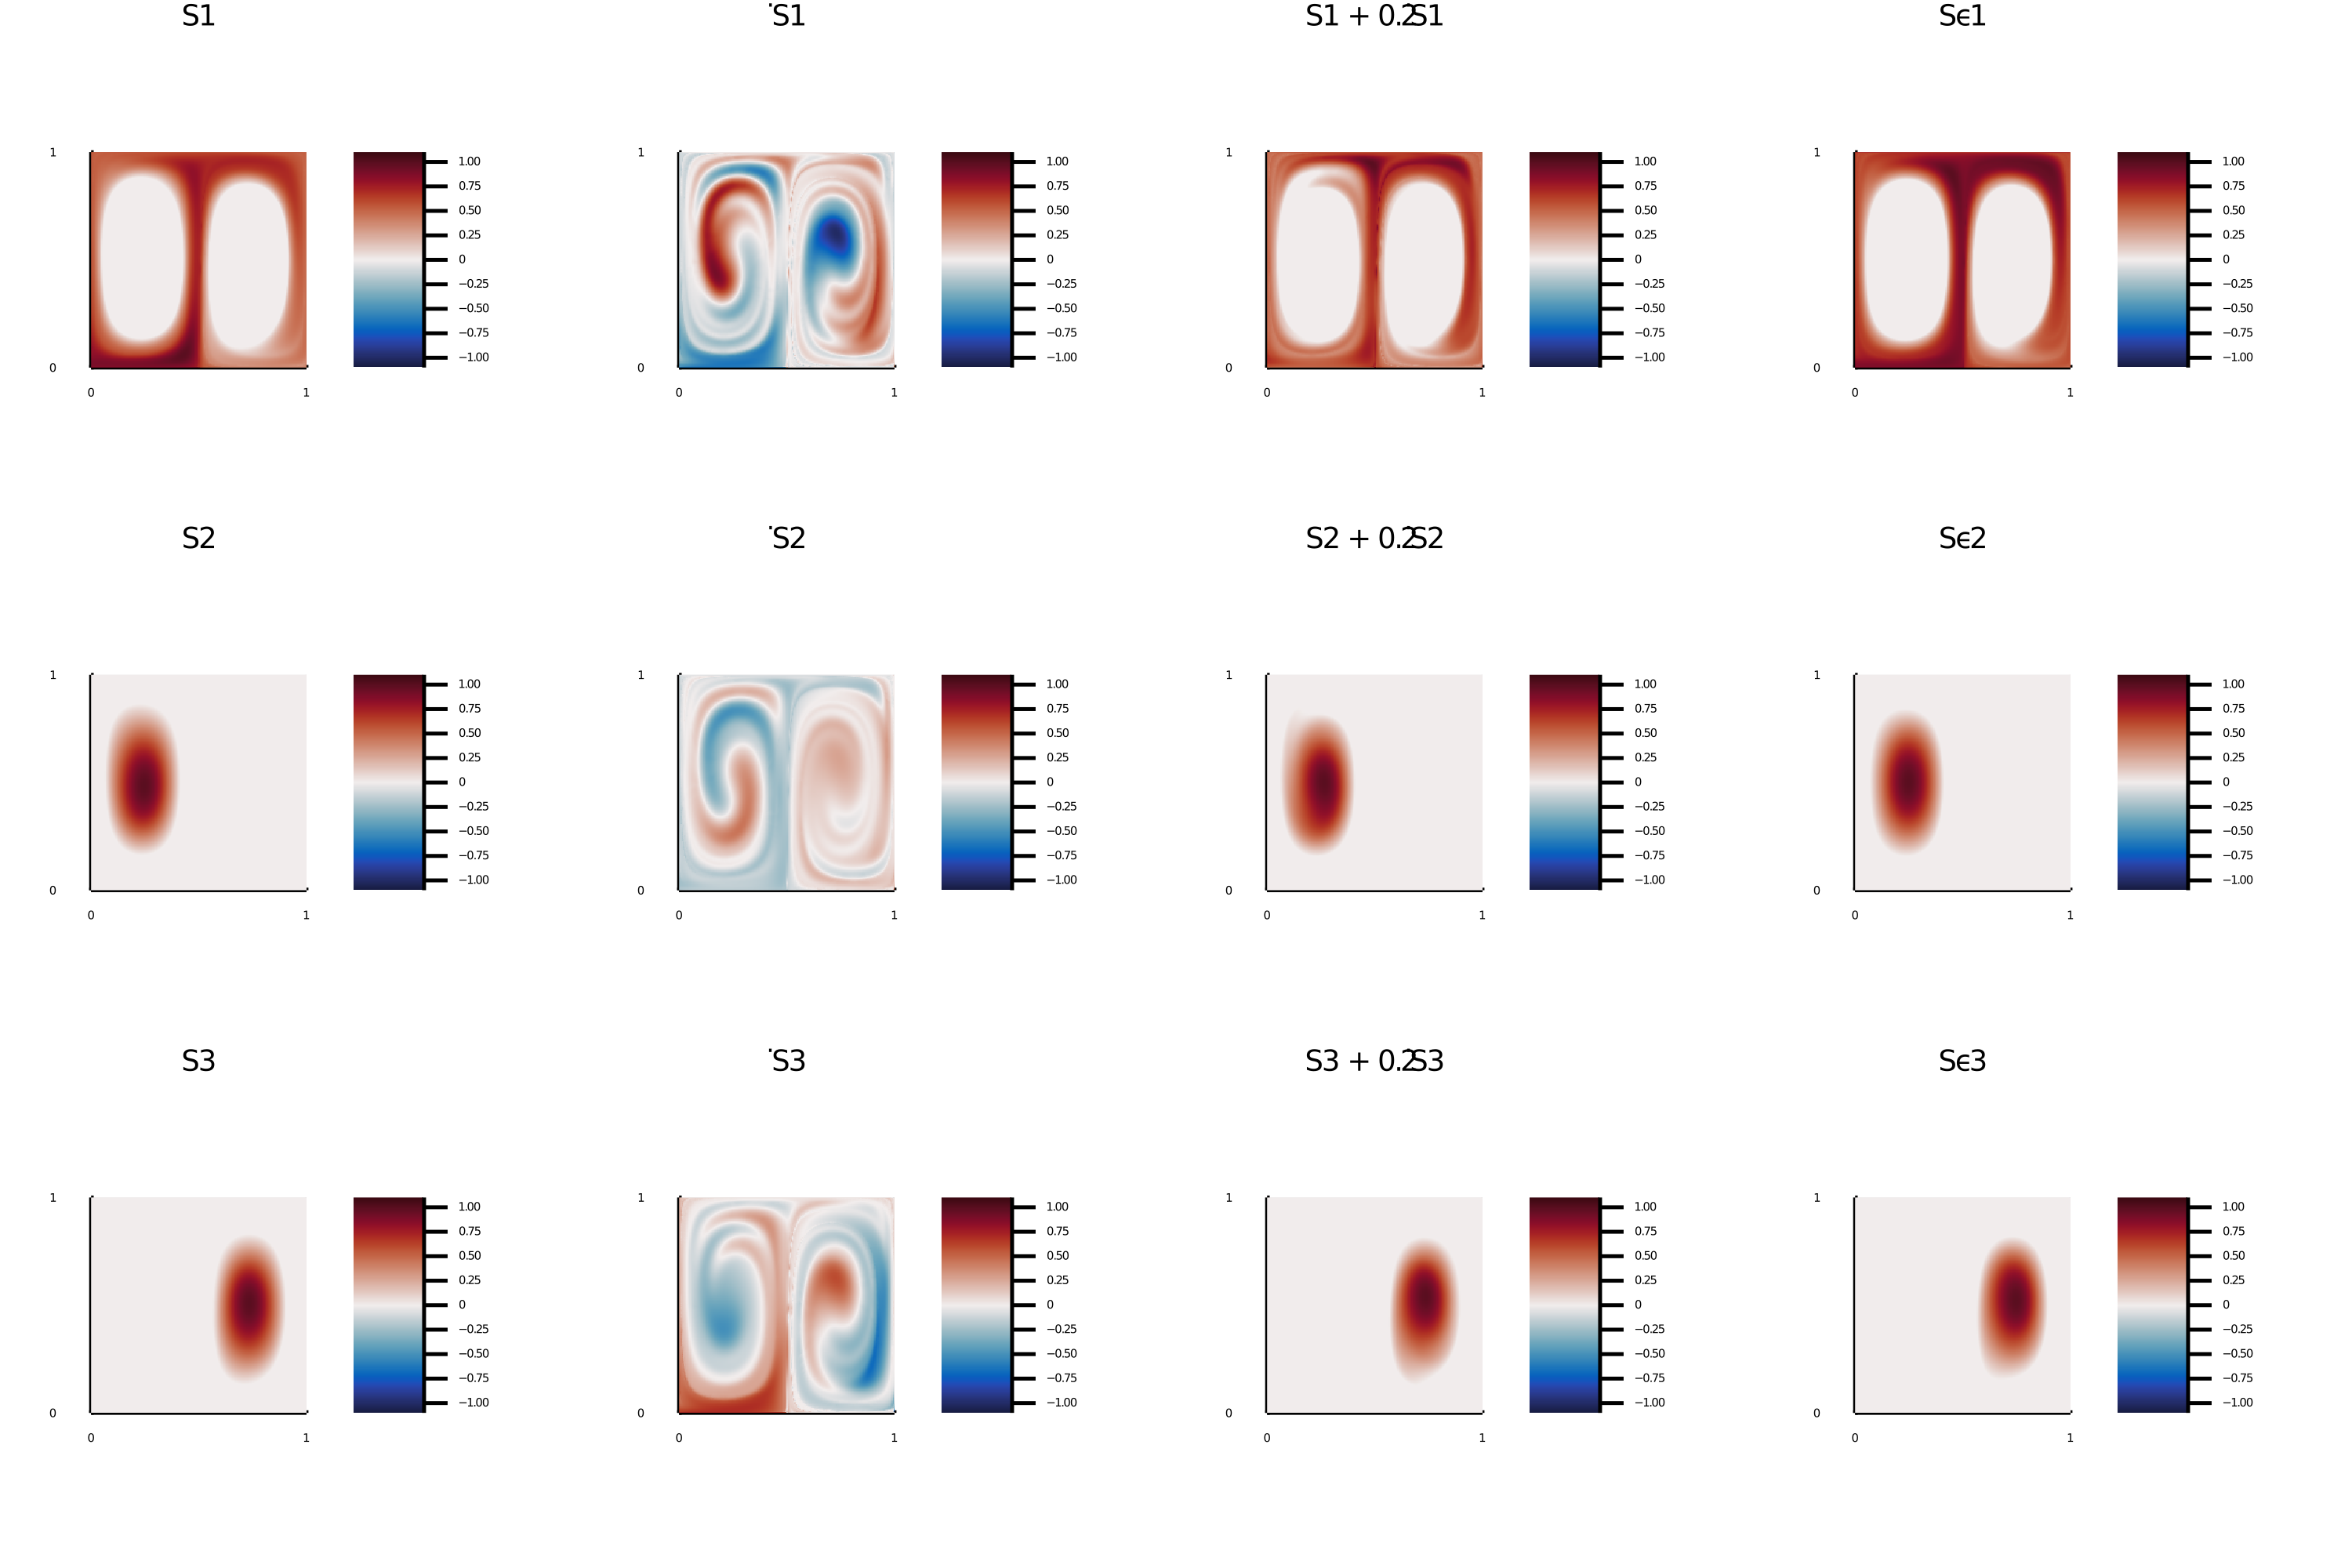

In [44]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            grid_resolution, grid_resolution, 
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            grid_resolution, grid_resolution, 
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            grid_resolution, grid_resolution, 
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            grid_resolution, grid_resolution, 
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

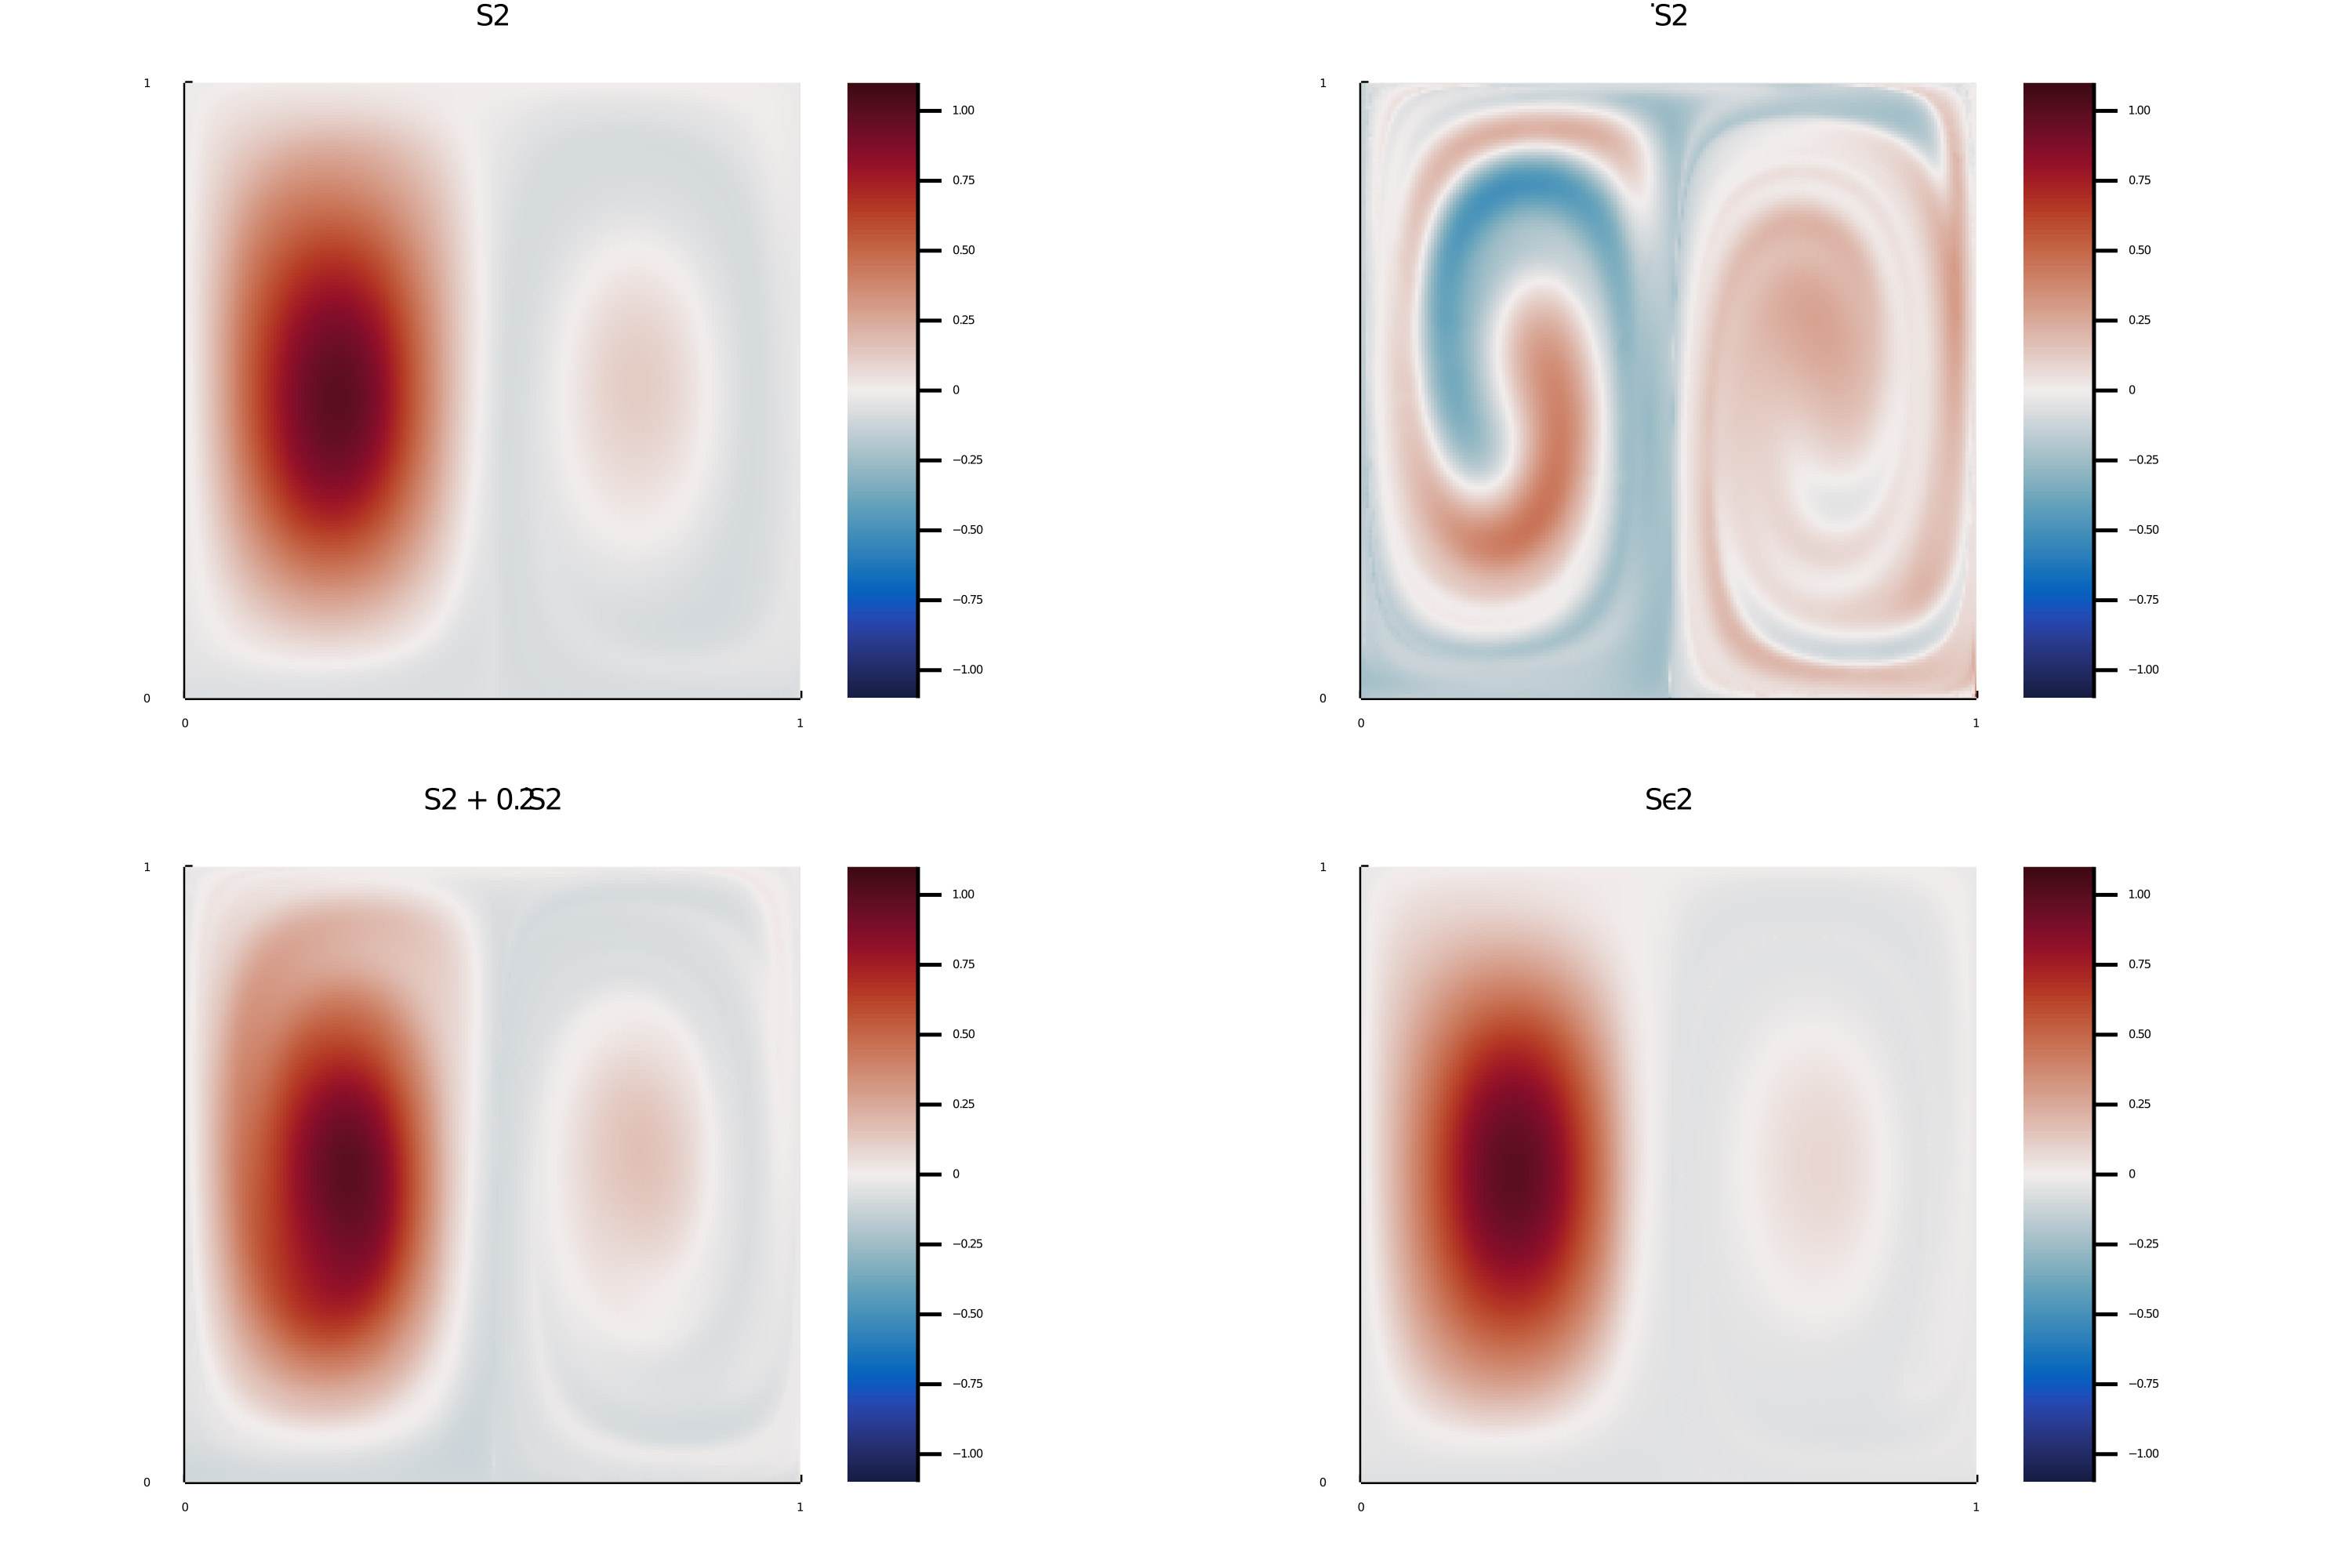

In [45]:
plots = []
push!(plots,plot_u(ctx, normalizeU(S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S′[:,ev] + ϵ*S_dot[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

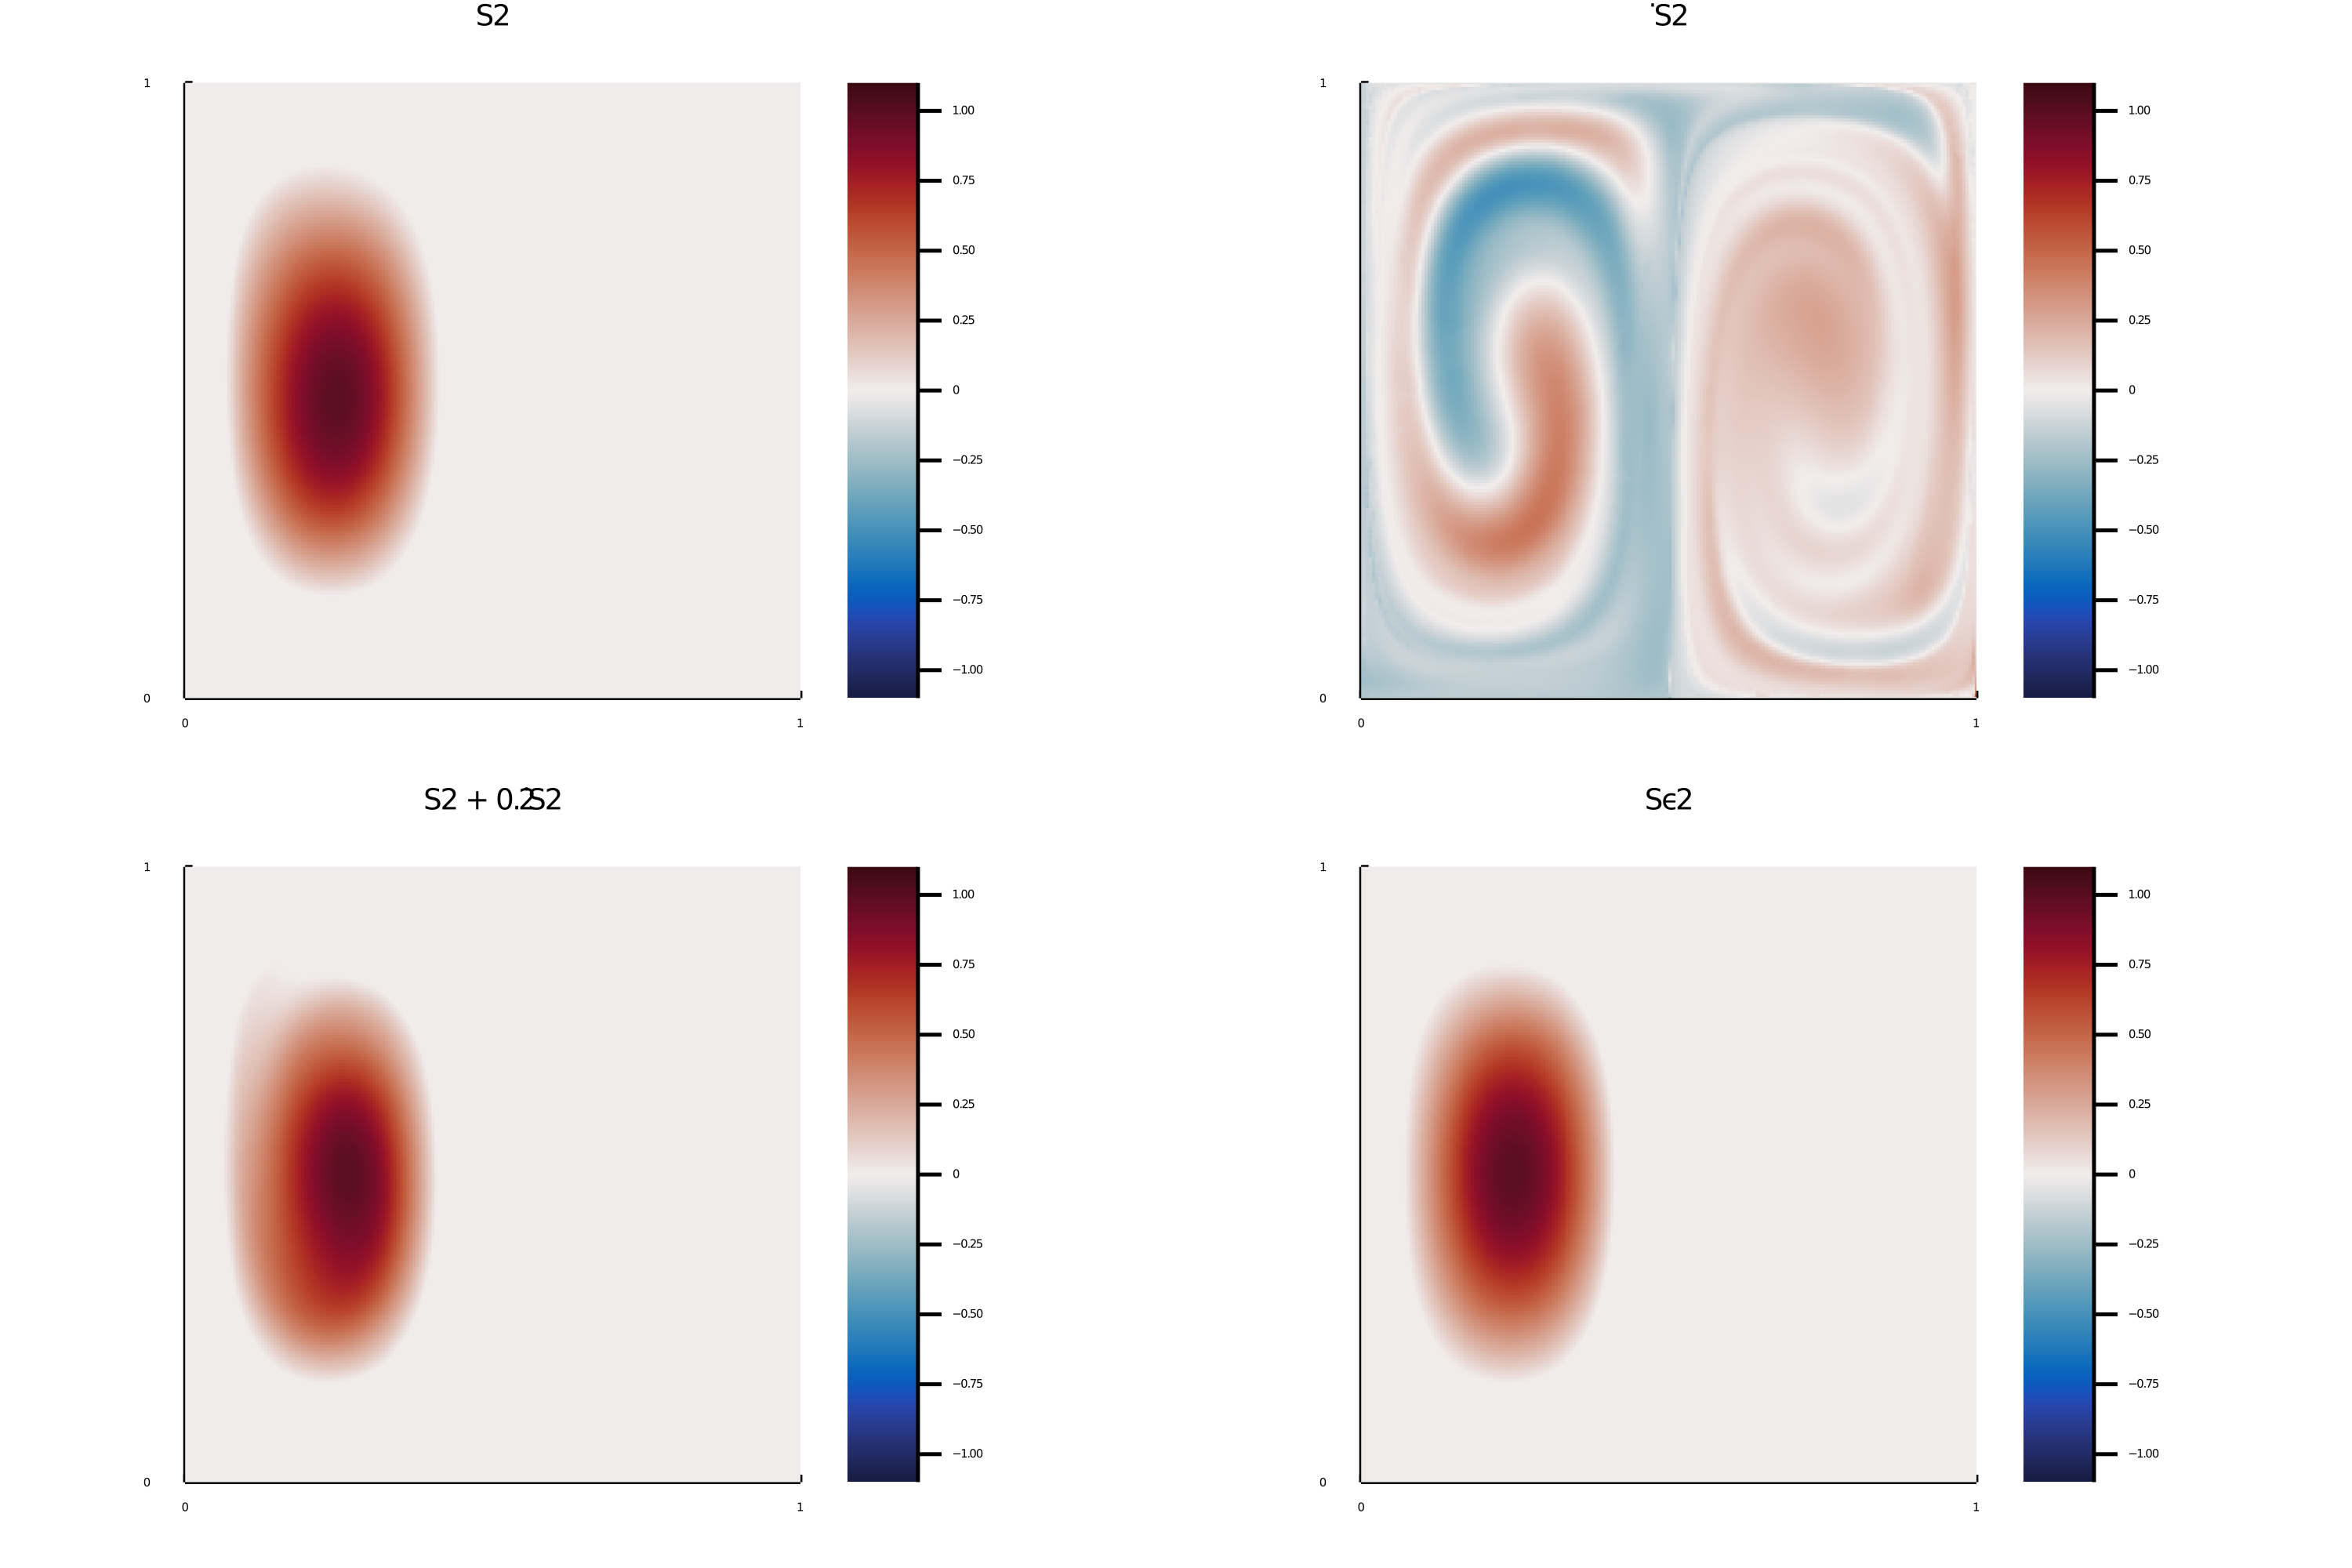

In [46]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

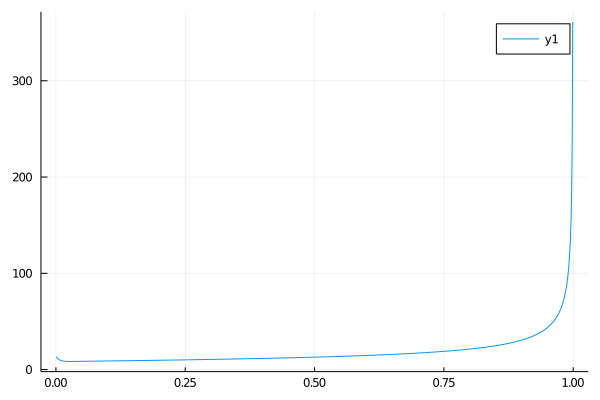

In [47]:
minU = minimum(S[:,ev])
maxU = maximum(S[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c,x_resolution=x_resolution,y_resolution=y_resolution)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

In [48]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

Dynamic Cheeger value:	8.46375886012888
Levelset:		0.025025025025025027


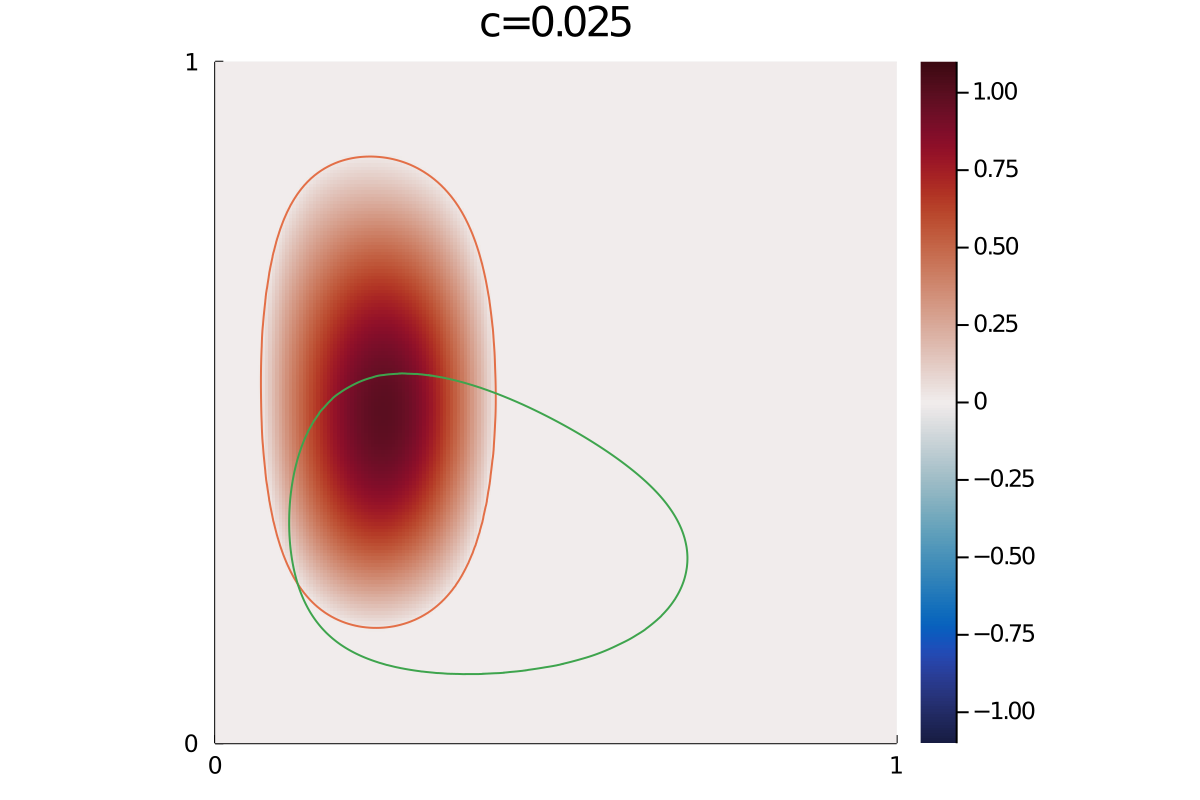

In [49]:
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

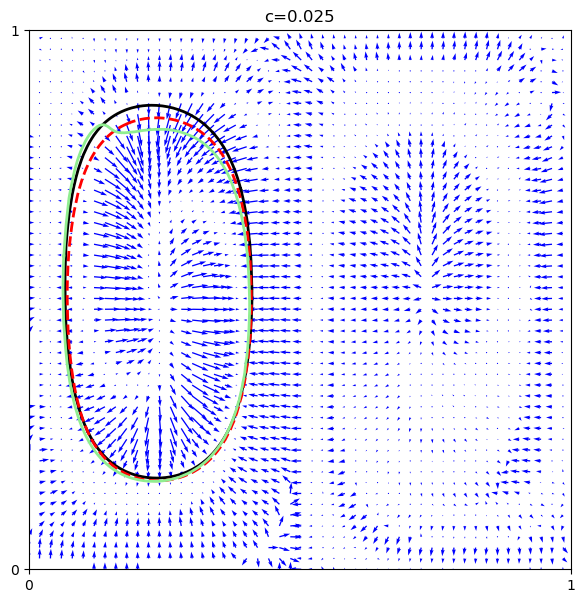

In [50]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
# this is not completely straightforward due to the nonlinearity of softThreshold!
plot_vectorfield(get_levelset_evolution(ctx,normalizeU(S′[:,ev]),S_dot[:,ev])...,ax,scale=0.2,step=4)
curves           = lines(get_levelset(ctx, S[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),
                         c_best,x_resolution=x_resolution,y_resolution=y_resolution))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

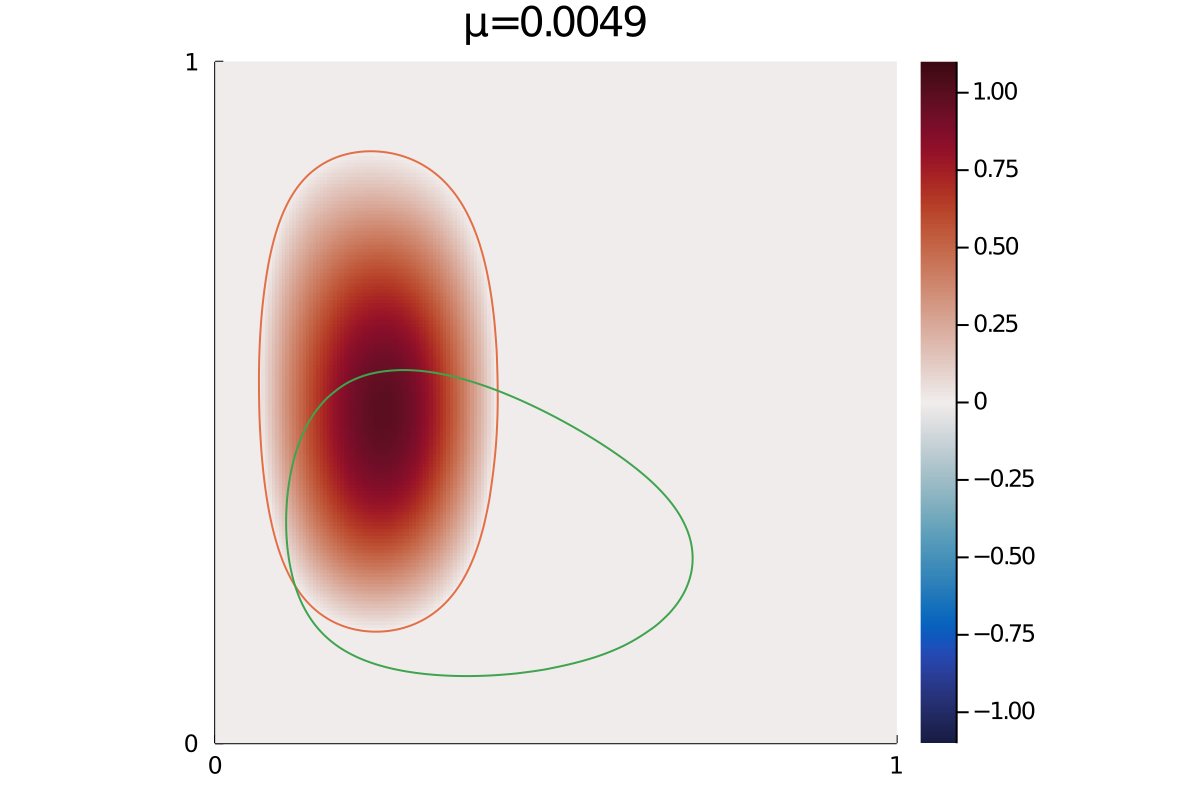

In [51]:
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="μ=$(round(μ,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(Main.CoherentStructures.get_levelset(ctx,S′[:,ev],μ,
        x_resolution=x_resolution,y_resolution=y_resolution))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value_matlab(curves[1])

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

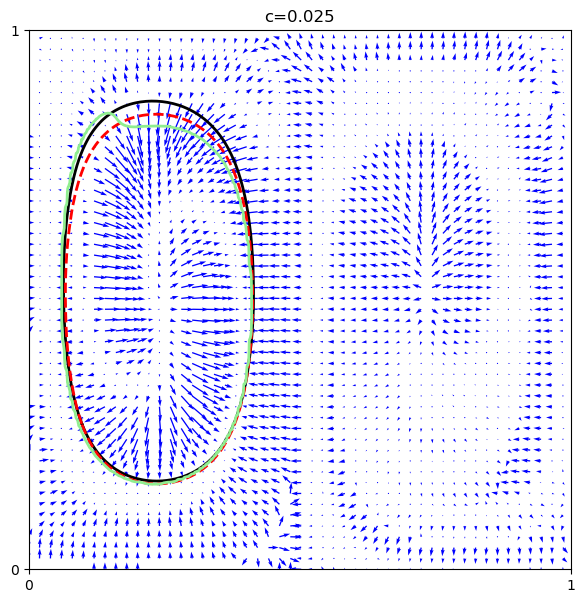

In [52]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,S′[:,ev],S_dot[:,ev])...,ax,scale=0.2,step=4)
curves           = lines(get_levelset(ctx, S′[:,ev],μ,x_resolution=x_resolution,y_resolution=y_resolution))
curves_epsilon   = lines(get_levelset(ctx, Sϵ′[:,ev],μ,x_resolution=x_resolution,y_resolution=y_resolution))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),
                         μ,x_resolution=x_resolution,y_resolution=y_resolution))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");